In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from typing import List
from collections import OrderedDict
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [24]:
class Segmentations:
    def __init__(self,
                 path_to_seg_file: str,
                 song_names: List[str]):
        segment_mappings, self.segments, _ = \
            np.load(path_to_seg_file, allow_pickle=True)
        self.song_names = [name.upper() for name in song_names]
        self.segment_mappings = OrderedDict((v, k) for k, v in segment_mappings.items())
    
    def get_song_name_range(self, name):
        song_idx = self.song_names.index(name)
        if song_idx == -1:
            raise ValueError(f"Song {song} not found.")
        segment_idx = self.segment_mappings[song_idx]
        return list(range(segment_idx, segment_idx + len(self.segments[song_idx])))

In [25]:
musdb_root = "/exports/projects/computer-audition/data/musdb/raw/stems/"
train_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "train"))])
train_segmentations = Segmentations("train_segmentation.npy", train_songs)
test_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "test"))])
test_segmentations = Segmentations("test_segmentation.npy", test_songs)

test_data = {}
test_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented/aggreggate.csv")
test_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented/aggreggate.csv")
test_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented/aggreggate.csv")
test_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented/aggreggate.csv")
         
train_data = {}
train_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented_train/aggreggate.csv")
train_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented_train/aggreggate.csv")
train_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented_train/aggreggate.csv")
train_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented_train/aggreggate.csv")

genre_metadata = pd.concat([
    pd.read_csv("medleydb_genre.csv"), pd.read_csv("dsd_genre.csv", quotechar='"'), pd.read_csv("self_labeled.csv")
],axis=0).reset_index()[["Artist - Title", "Genre"]]
genre_metadata["Artist - Title"] = genre_metadata["Artist - Title"].apply(lambda name: name.replace(" Multitracks", "").upper())
genre_metadata["Split"] = genre_metadata["Artist - Title"].apply(
    lambda name: 'train' if name in train_segmentations.song_names
                         else ('test' if name in test_segmentations.song_names
                                      else None)
)
# Combining pop and rock together, because DSD combines them
genre_metadata["Genre"] = genre_metadata["Genre"].apply(lambda name: "Pop/Rock" if name in ["Pop", "Rock"] else name)
genre_metadata_valid = genre_metadata[(genre_metadata["Split"] == 'test') | (genre_metadata["Split"] == 'train')]

In [26]:
genres = genre_metadata_valid["Genre"].value_counts()
display(genres)

Pop/Rock             97
Singer/Songwriter    16
Heavy Metal          12
Electronic            9
Rap                   8
Jazz                  3
Musical Theatre       2
Reggae                2
Country               1
Name: Genre, dtype: int64

In [27]:
def split_by_sources(df):
    return {name: g_df for name, g_df in df.groupby(by="source")}
test_data_sources = {k: split_by_sources(df) for k, df in test_data.items()}
train_data_sources = {k: split_by_sources(df) for k, df in train_data.items()}

In [42]:
def display_genre_info(sources_data, genre, split):
    """
    Things this function should do:
     - Output SNR, SI-SDR, and SI-SAR for each source
     - Density plot of SI-SDR vs. MIX-SI-SDR
    """
    assert split in ["train", "test"]
    def _filter_files(song_df):
        # this might be slow...
        song_names = song_df["Artist - Title"]
        segmentation = train_segmentations if split == "train" else test_segmentations
        song_numbers = set(sum([
            segmentation.get_song_name_range(name)
            for name in song_names
        ], []))
        filtered_data = {}
        for source, df in sources_data.items():
            filtered_data[source] = df[df["file"].apply(
                lambda file: (int(file.split(".")[0]) in song_numbers)
            )]
        return filtered_data
    
    def _generate_aggregations(sources_data):
        agg = {}
        sources = list(sources_data.keys())
        for source in sources:
            for metric in ["SNR", "SI-SDR", "SI-SAR"]:
                mean = sources_data[source][metric].mean()
                agg[metric] = agg.get(metric, []) + [mean]
        return pd.DataFrame(agg, index=sources)
                
    
    def _generate_graphs(sources_data):
        fig, axes = plt.subplots(1, len(sources_data), figsize=(12, 3))
        for idx, (source, source_df) in enumerate(sources_data.items()):
            ax = axes[idx]
            ax.set_title(source)
            x = source_df["MIX-SI-SDR"]
            y = source_df["SI-SDR"]
            xy = np.vstack([x.to_numpy(), y.to_numpy()])
            z = gaussian_kde(xy)(xy)
            sns.scatterplot(x=x, y=y, hue=z*10, ax=ax, legend=False)
        return fig
    
    song_df = genre_metadata_valid[(genre_metadata_valid["Genre"] == genre)
                                   & (genre_metadata_valid["Split"] == split)]
    filtered_df = _filter_files(song_df)
    if len(list(filtered_df.values())[0].index) == 0:
        display(f"No songs for genre {genre} and split {split}")
        return
    display(_generate_aggregations(filtered_df))
    display(_generate_graphs(filtered_df))


# This is a metric ton of information, and will have to be rearranged to draw conclusions for it. 
# TODO: Make this pleasing to the eye.

# Test

OPENUNMIX
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    5.168985  2.951297  3.943815
drums   6.090812  4.613090  5.151488
other   4.082261  1.669686  2.765086
vocals  6.199123  4.813917  5.455244

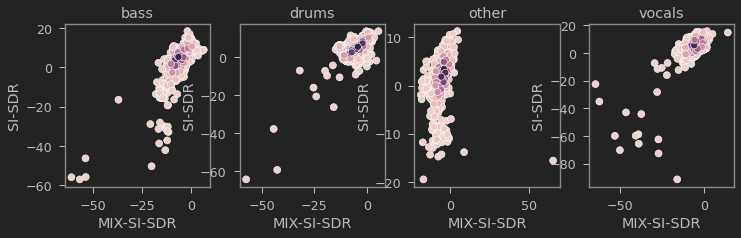

SINGER/SONGWRITER


SNR     SI-SDR     SI-SAR
bass     4.503944   2.540967   5.485651
drums   11.641024  11.342516  11.653101
other    0.723243  -5.968477  -4.700091
vocals   6.960144  -0.150619  -0.015866

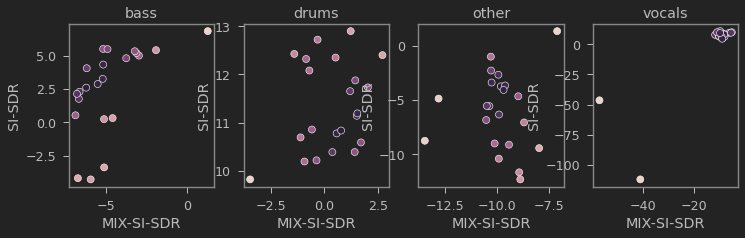

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    1.768165 -1.739464 -0.303581
drums   5.131354  3.260307  4.086056
other   5.857747  4.427926  6.018615
vocals  4.873553  1.431324  1.764827

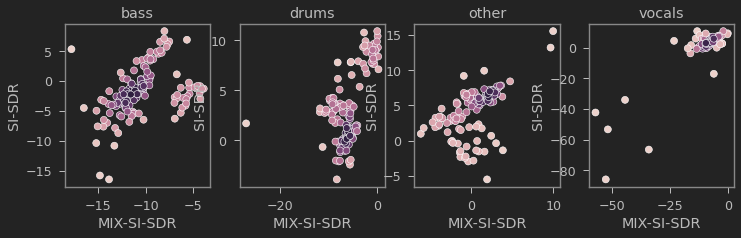

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    3.204771  0.299266  0.672535
drums   6.637079  5.543366  7.416020
other   1.304447 -6.265001 -4.698386
vocals  1.424797 -4.123877 -3.389241

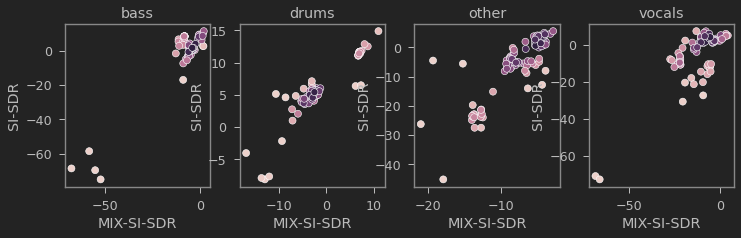

RAP


SNR    SI-SDR    SI-SAR
bass    6.508823  5.347493  5.921120
drums   7.496616  6.450957  6.667402
other   2.560855 -0.560258  0.205841
vocals  8.277548  7.602518  8.299020

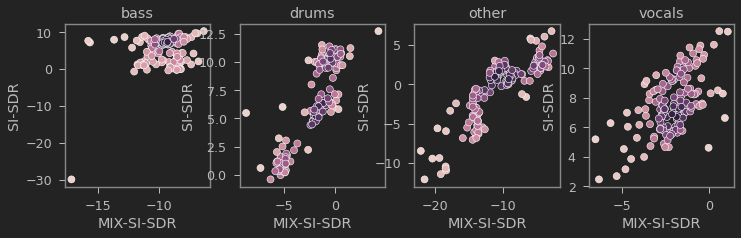

JAZZ


'No songs for genre Jazz and split test'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split test'

REGGAE


SNR    SI-SDR    SI-SAR
bass    1.570122  0.386405  5.494461
drums   1.471979 -2.753477 -1.925573
other   0.620332 -4.446942 -4.007695
vocals  8.018321  7.248052  7.630071

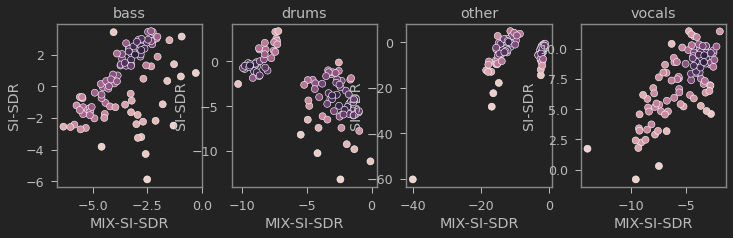

COUNTRY


'No songs for genre Country and split test'

DEMUCS
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    6.396740  4.828559  5.359099
drums   7.289011  6.193081  6.493570
other   4.414311  2.396833  3.494128
vocals  6.636460  5.004273  5.571235

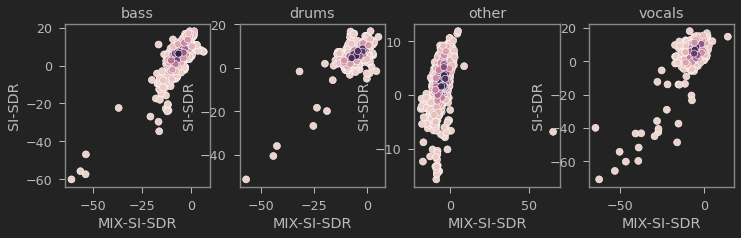

SINGER/SONGWRITER


SNR     SI-SDR     SI-SAR
bass     4.829849   3.147610   4.534957
drums   12.106830  11.983561  12.178953
other    1.174548  -3.197608  -1.089462
vocals   7.752982   5.171703   5.491704

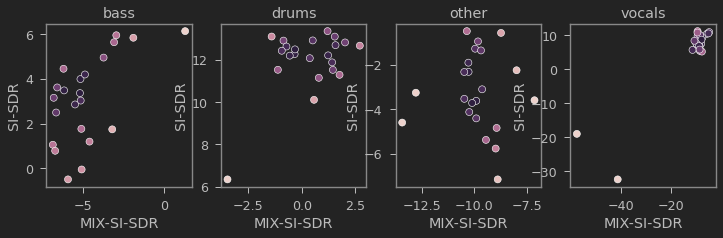

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    2.395849 -0.458370  0.468839
drums   5.947273  4.396554  4.817187
other   6.447642  5.354394  6.700429
vocals  4.666339  1.270103  1.567508

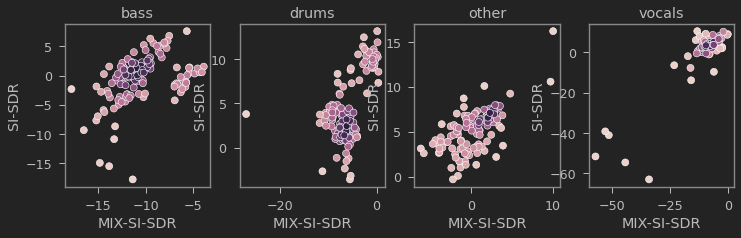

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    4.111588  1.476559  1.741222
drums   7.501867  6.553195  7.351279
other   1.954867 -1.525333  0.130193
vocals  2.092294 -5.251018 -4.518786

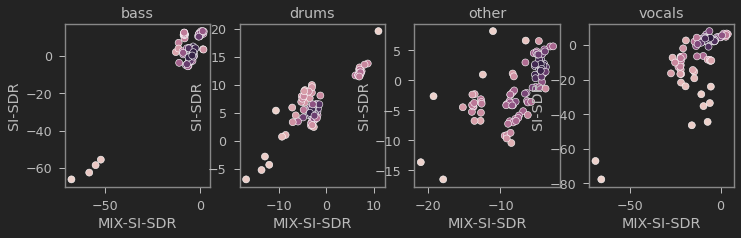

RAP


SNR    SI-SDR    SI-SAR
bass     8.427875  7.997005  8.336421
drums   10.149373  9.684150  9.918185
other    2.873240 -0.386611  0.269169
vocals   9.149390  8.540083  9.176911

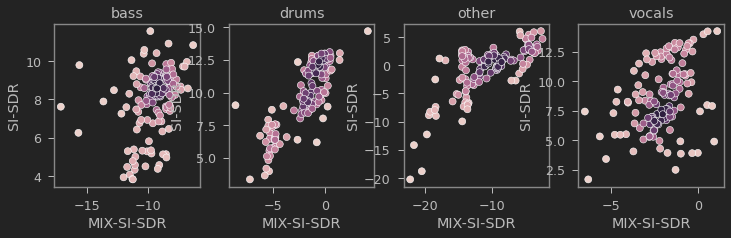

JAZZ


'No songs for genre Jazz and split test'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split test'

REGGAE


SNR    SI-SDR    SI-SAR
bass    3.291673  2.189519  4.959005
drums   2.102460  0.206302  1.305423
other  -0.575958 -4.347227 -3.609164
vocals  8.840814  8.200293  8.490636

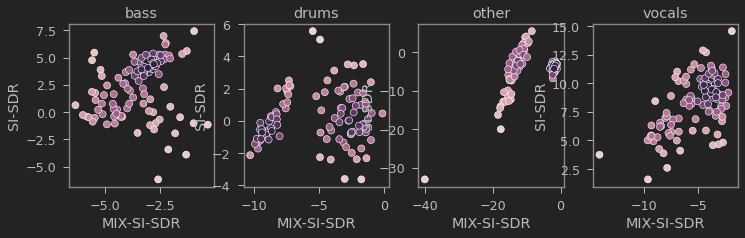

COUNTRY


'No songs for genre Country and split test'

CONVTASNET
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    6.812402  4.684500  5.207728
drums   7.565850  6.379744  6.750888
other   4.672835  2.555404  3.560717
vocals  6.756412  4.949804  5.962542

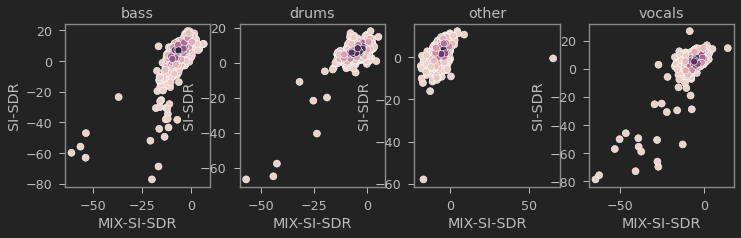

SINGER/SONGWRITER


SNR     SI-SDR     SI-SAR
bass     5.284948   4.070600   7.246398
drums   13.042692  12.853141  12.980193
other    1.465209  -4.174522  -3.582811
vocals   8.400760   5.381183   5.660228

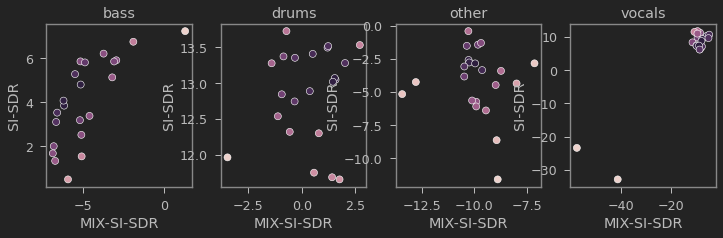

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    3.099906 -0.593750  0.207511
drums   5.986118  4.561410  5.144409
other   6.510961  5.438570  6.613860
vocals  4.697474  1.208268  1.729732

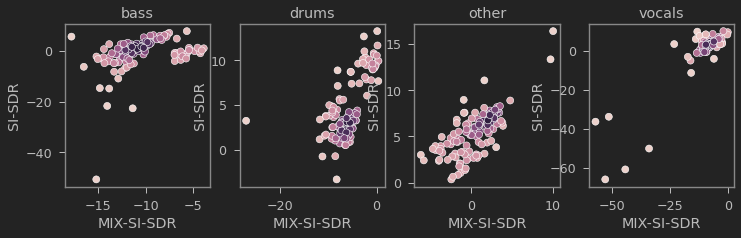

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    4.254537 -1.815273 -1.530366
drums   7.472078  6.769382  8.633636
other   2.394806 -1.984504 -0.146510
vocals  2.039990 -6.330544 -5.451816

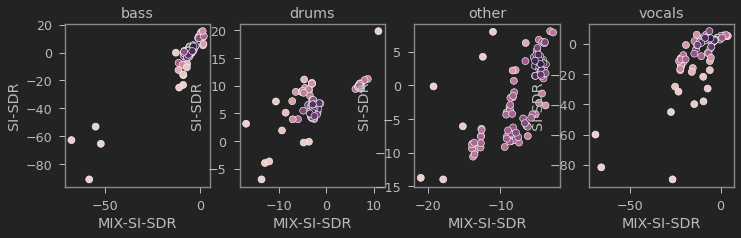

RAP


SNR     SI-SDR     SI-SAR
bass     8.702419   8.235325   8.457393
drums   10.712955  10.282548  10.537163
other    3.486236  -0.208840   0.181964
vocals   9.620222   9.067454   9.997677

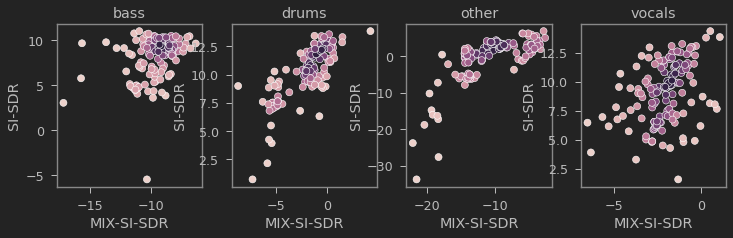

JAZZ


'No songs for genre Jazz and split test'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split test'

REGGAE


SNR    SI-SDR    SI-SAR
bass    3.239564  2.477363  6.071813
drums   5.402915  3.644547  3.918064
other   1.234741 -3.992129 -3.599928
vocals  9.475566  8.975720  9.409153

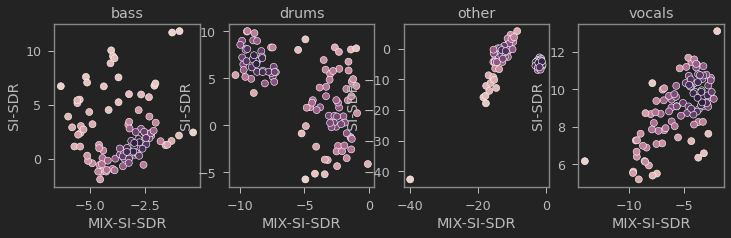

COUNTRY


'No songs for genre Country and split test'

WAVE-U-NET
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    3.302009  0.619451  1.455690
drums   4.175247  1.542574  1.882865
other   2.525199 -1.042234  0.932113
vocals  4.375097  1.904172  3.214492

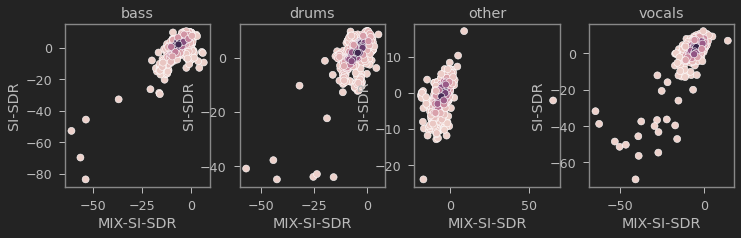

SINGER/SONGWRITER


SNR    SI-SDR    SI-SAR
bass    1.391383 -4.070880 -3.134095
drums   8.704301  8.350656  8.510260
other   0.575764 -6.406207 -3.368425
vocals  6.155288  1.655248  1.834088

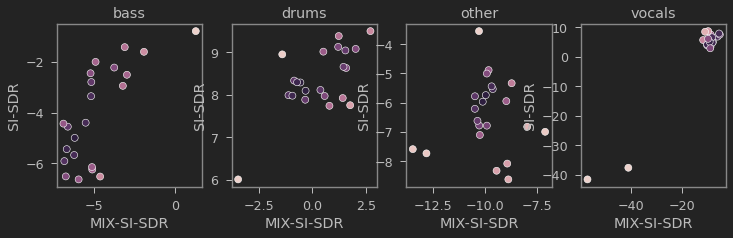

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    0.216830 -3.836061 -2.622231
drums   4.028100  1.453434  1.868237
other   4.305929  2.487610  4.371101
vocals  3.076506 -1.731177 -0.985938

/home/ubuntu/anaconda3/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


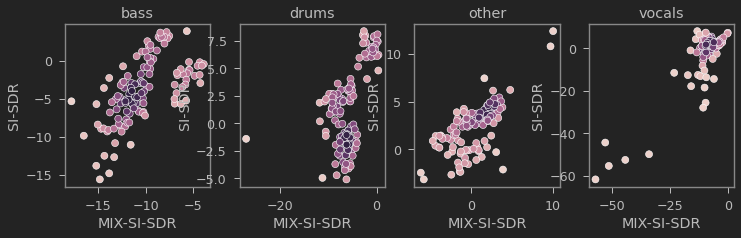

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    1.368744 -2.867569 -2.147587
drums   4.394639  1.935693  2.807280
other   1.926934 -5.959825 -4.152566
vocals  1.734942 -5.222806 -4.090123

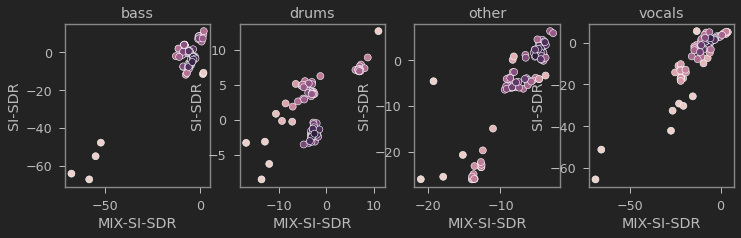

RAP


SNR    SI-SDR    SI-SAR
bass    2.030772 -0.159878  0.656755
drums   4.685038  2.646366  2.840792
other   0.933044 -5.475890 -3.831635
vocals  5.892179  4.549739  5.392948

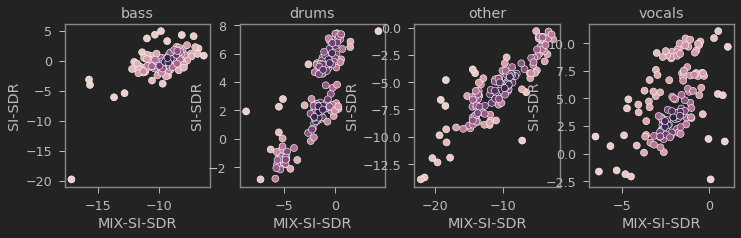

JAZZ


'No songs for genre Jazz and split test'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split test'

REGGAE


SNR     SI-SDR     SI-SAR
bass    1.595503  -0.852341   1.989212
drums   0.319771  -5.423399  -4.313186
other  -0.536805 -11.314880 -10.190412
vocals  6.319372   4.724347   5.182360

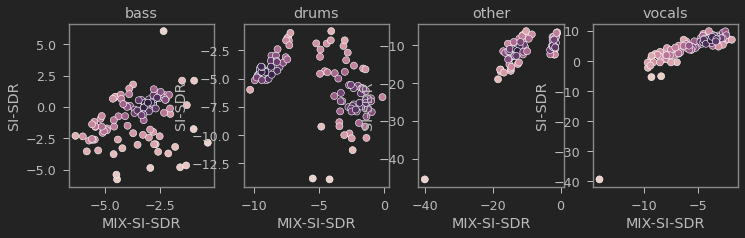

COUNTRY


'No songs for genre Country and split test'

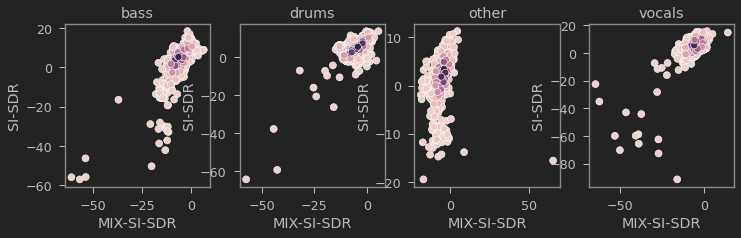

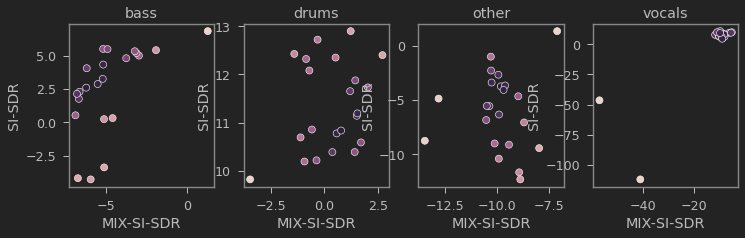

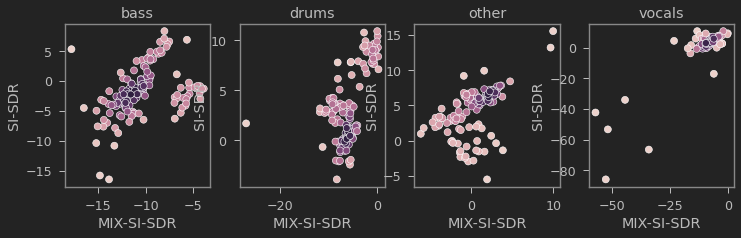

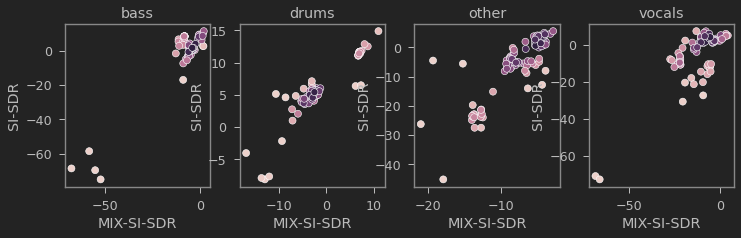

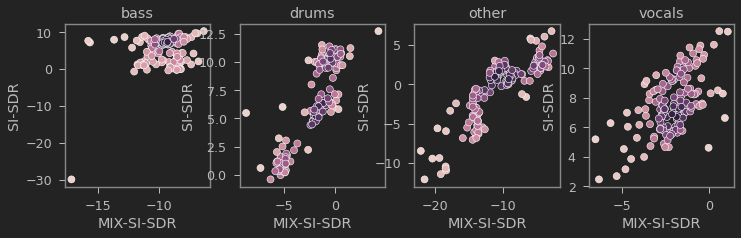

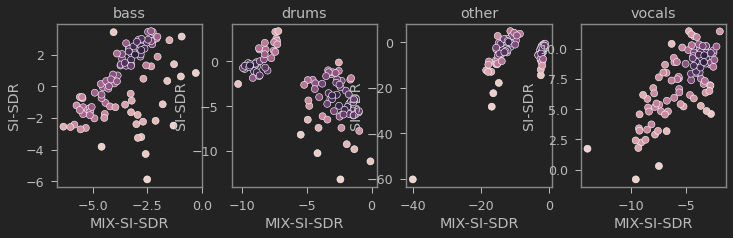

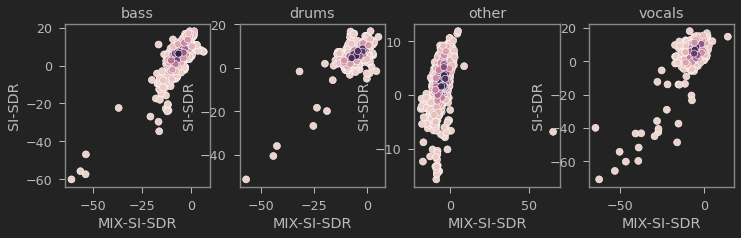

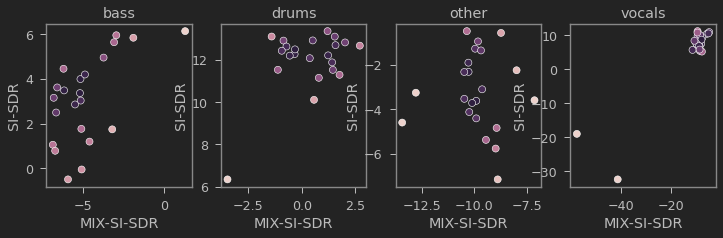

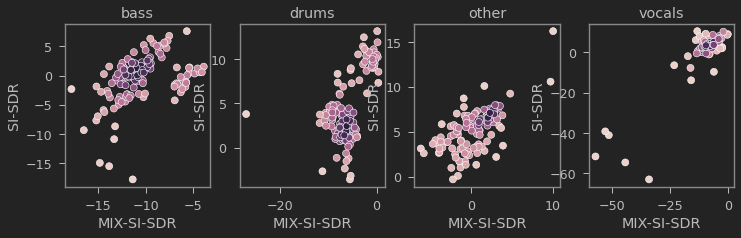

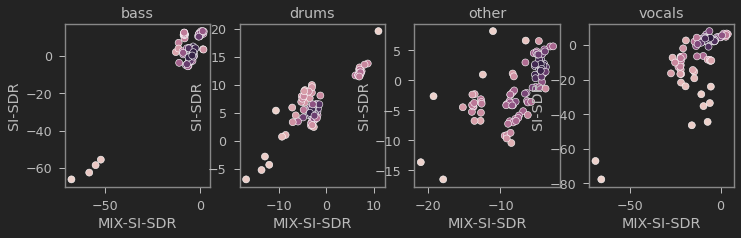

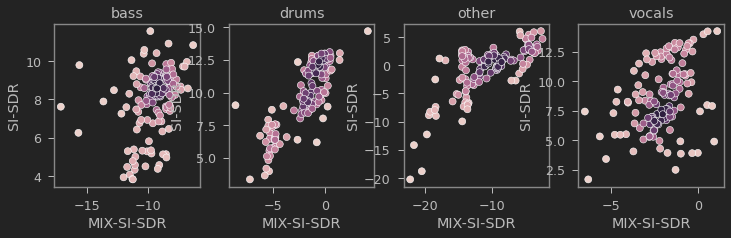

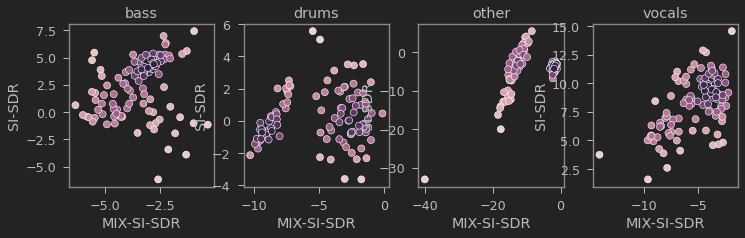

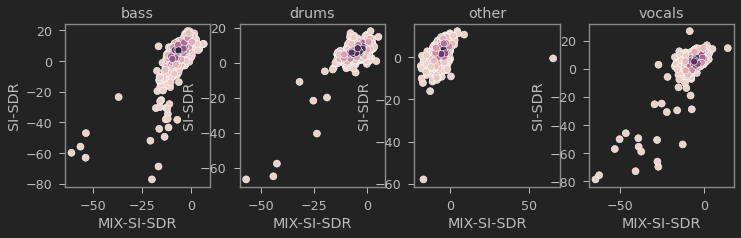

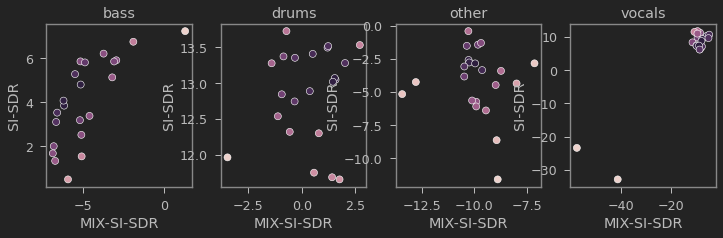

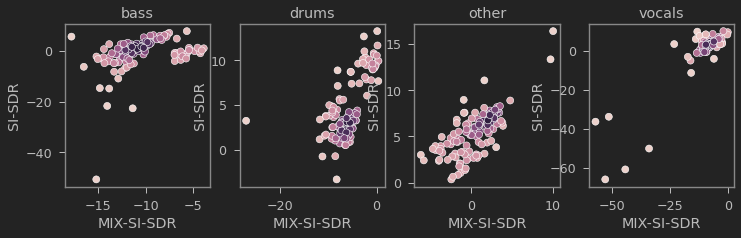

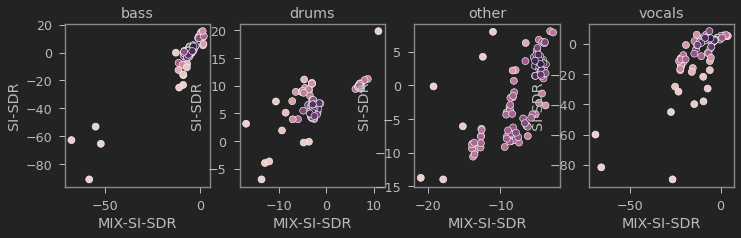

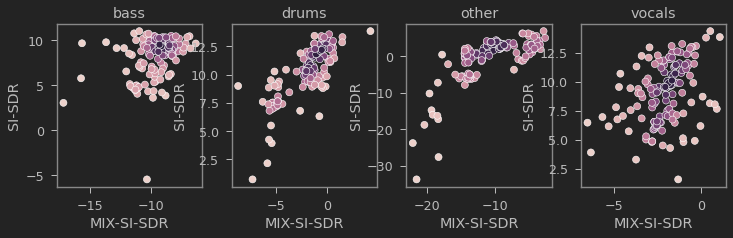

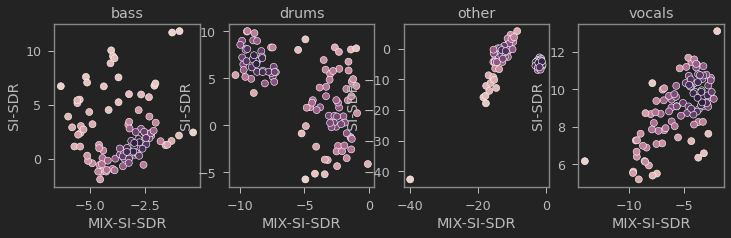

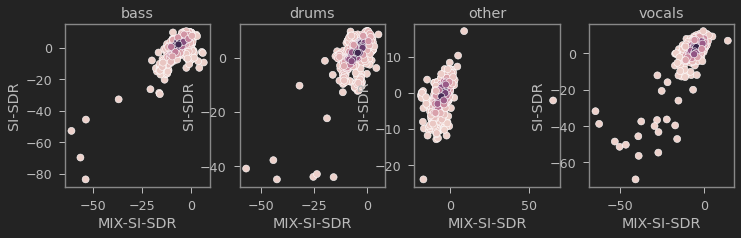

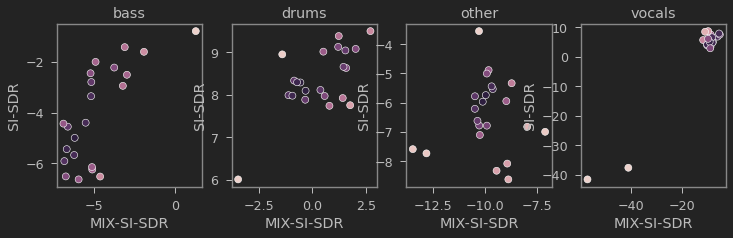

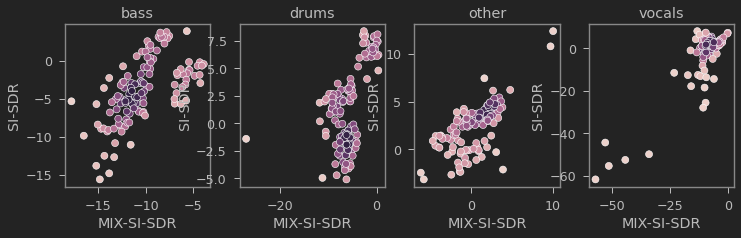

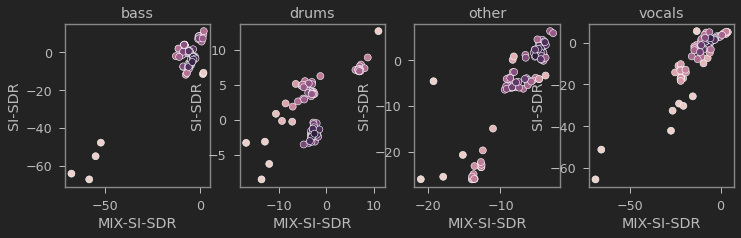

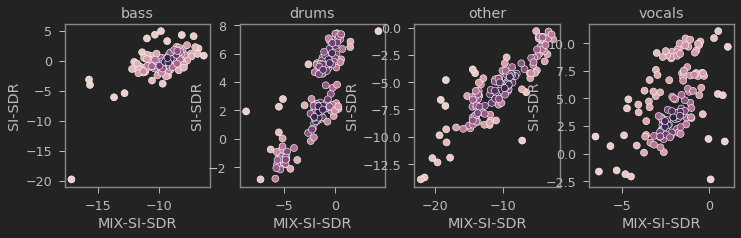

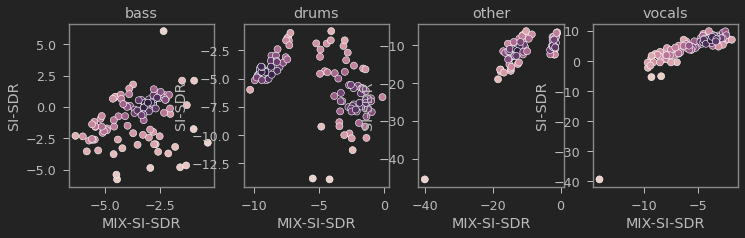

In [43]:
for key, sources_data in test_data_sources.items():
    print(key.upper())
    for genre in genres.index:
        print(genre.upper())
        display_genre_info(sources_data, genre, "test")

# Train

OPENUNMIX
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    5.119757  3.143778  4.312098
drums   6.264568  4.721105  5.279808
other   3.450664  0.612780  1.678001
vocals  5.869125  4.362771  5.067613

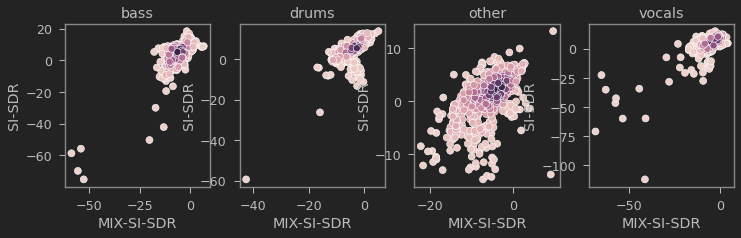

SINGER/SONGWRITER


SNR    SI-SDR    SI-SAR
bass    3.850590  1.079444  2.637382
drums   5.969533  4.198472  4.781029
other   3.951871  1.288082  2.426329
vocals  6.598046  4.651278  5.228268

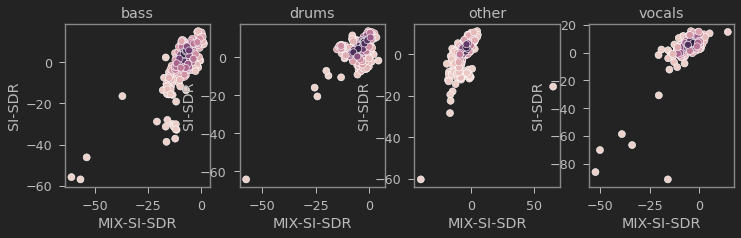

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    4.719549  1.886182  2.501703
drums   5.649538  3.978743  5.009763
other   4.276706 -0.801864  0.565048
vocals  3.452339 -0.126493  0.316333

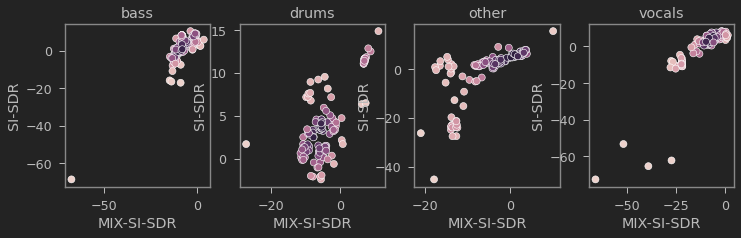

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    4.626549  3.143857  4.381693
drums   5.607126  4.113146  4.525688
other   4.204775  2.138891  2.900581
vocals  7.622314  6.471841  7.052408

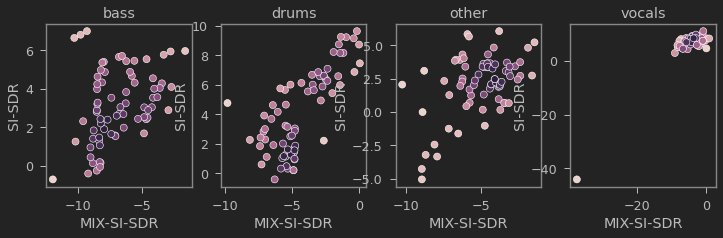

RAP


SNR    SI-SDR    SI-SAR
bass    5.068232  3.694317  5.021850
drums   4.208533  2.583488  3.331440
other   3.034293  0.035435  0.971056
vocals  7.261368  5.798266  6.183284

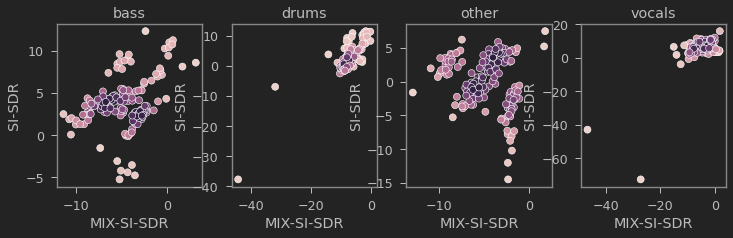

JAZZ


'No songs for genre Jazz and split train'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split train'

REGGAE


'No songs for genre Reggae and split train'

COUNTRY


SNR    SI-SDR    SI-SAR
bass    4.156360  1.909426  2.085888
drums   9.316755  8.773115  9.818341
other   4.077945  2.070697  3.645674
vocals  6.567877  5.486428  5.885337

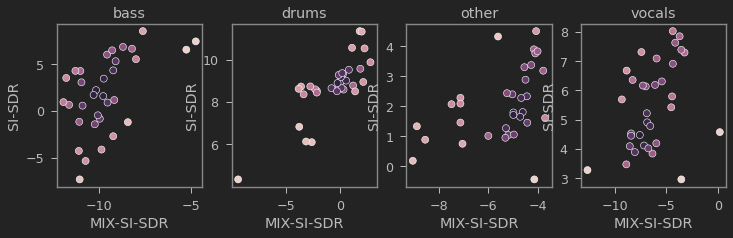

DEMUCS
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    6.133972  4.670713  5.353203
drums   7.491545  6.453454  6.769592
other   3.786395  1.417057  2.560773
vocals  6.317355  4.373601  5.003668

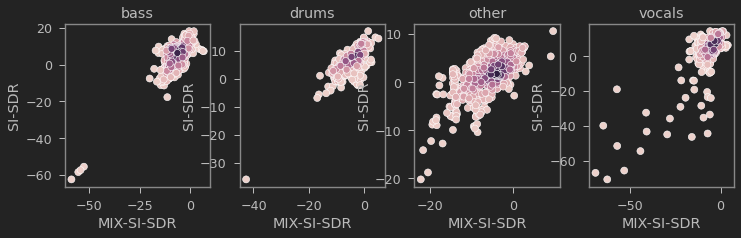

SINGER/SONGWRITER


SNR    SI-SDR    SI-SAR
bass    5.374072  3.319474  4.108323
drums   7.346308  6.108420  6.399266
other   4.146633  1.990133  3.166657
vocals  7.121623  5.315829  5.825255

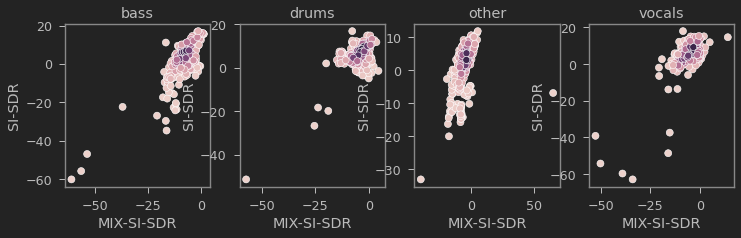

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    5.079902  2.922585  3.398736
drums   6.653038  5.359711  5.989549
other   4.222561  1.985351  3.006174
vocals  4.075133  0.015363  0.384483

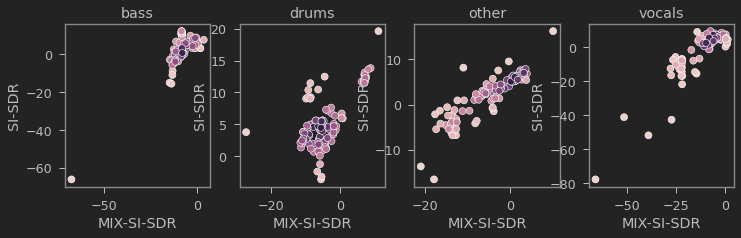

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    6.965743  6.198246  6.600252
drums   7.634966  6.769055  6.939540
other   4.605742  2.955952  3.842216
vocals  7.918435  6.592062  7.058217

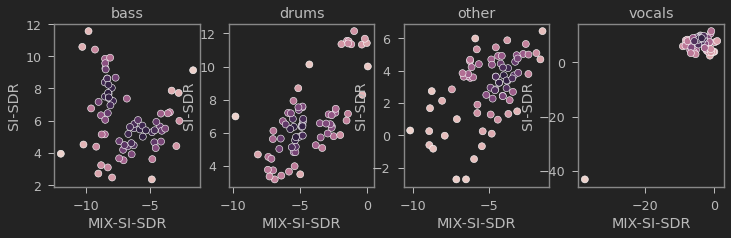

RAP


SNR    SI-SDR    SI-SAR
bass    6.654600  5.755865  6.479963
drums   5.052239  3.936672  4.756469
other   3.463335  0.831049  1.637732
vocals  7.781166  6.457975  6.852711

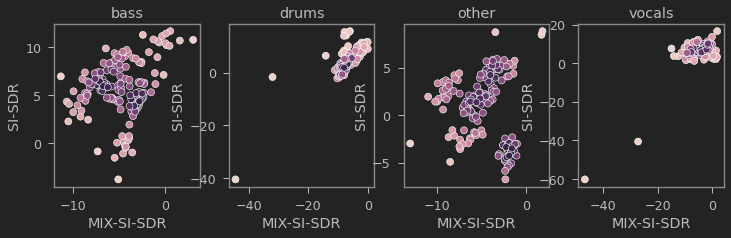

JAZZ


'No songs for genre Jazz and split train'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split train'

REGGAE


'No songs for genre Reggae and split train'

COUNTRY


SNR    SI-SDR    SI-SAR
bass    5.639623  4.076303  4.381350
drums   9.869962  9.409358  9.940737
other   4.359680  2.494855  3.709888
vocals  6.117958  4.852522  5.293325

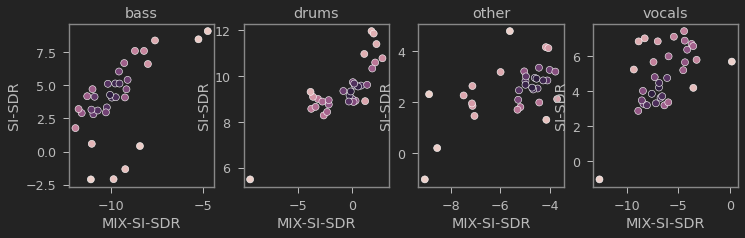

CONVTASNET
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    6.638067  4.528152  5.245655
drums   7.844686  6.796193  7.152515
other   4.064305  1.420317  2.546293
vocals  6.554527  4.507435  5.462613

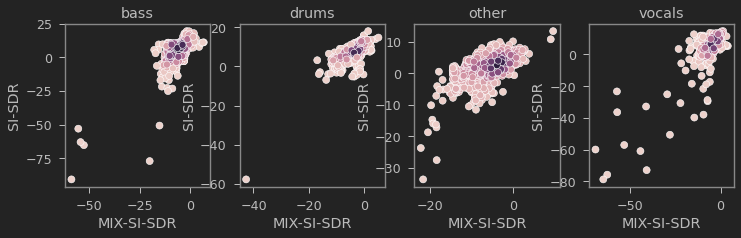

SINGER/SONGWRITER


SNR    SI-SDR    SI-SAR
bass    5.958484  3.086473  3.810775
drums   7.731336  6.449365  6.894264
other   4.762819  2.353025  3.249466
vocals  7.042963  5.429073  6.460310

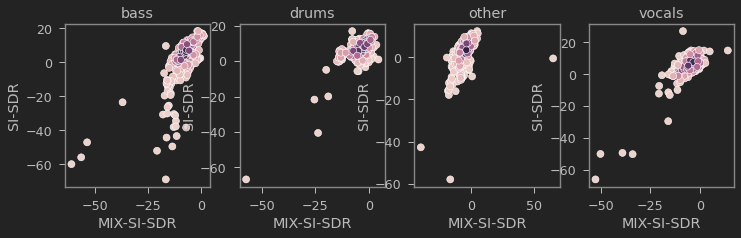

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    4.517870  1.325348  1.578976
drums   6.455154  5.350212  6.694633
other   4.545284  1.851224  2.852525
vocals  4.664591 -1.876595 -1.421465

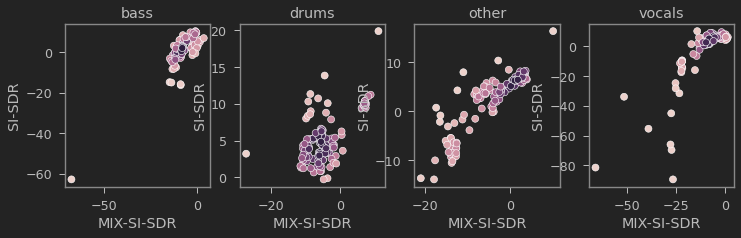

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    7.687726  6.881864  7.274214
drums   8.250066  7.469119  7.737977
other   4.833314  3.102404  3.791448
vocals  8.092713  6.544513  7.297070

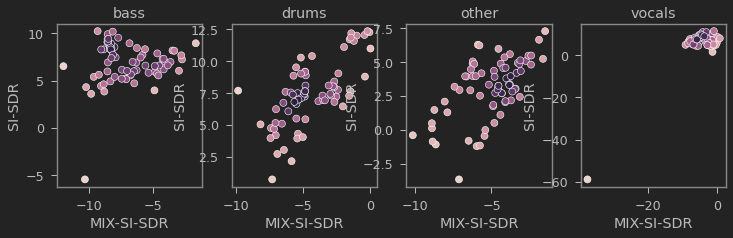

RAP


SNR    SI-SDR    SI-SAR
bass    6.527287  5.763344  7.210905
drums   6.747422  5.356899  5.637840
other   3.821897  0.907187  1.411168
vocals  8.161648  7.206979  7.982263

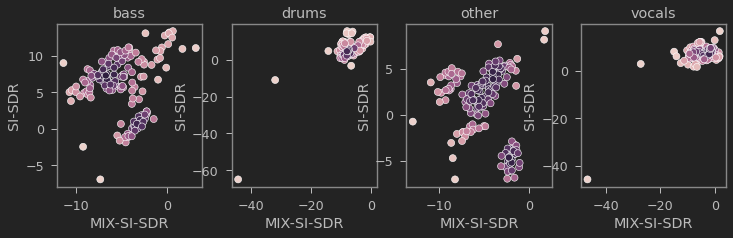

JAZZ


'No songs for genre Jazz and split train'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split train'

REGGAE


'No songs for genre Reggae and split train'

COUNTRY


SNR    SI-SDR     SI-SAR
bass    5.529173  2.863100   3.009115
drums   9.993659  9.553382  10.370904
other   4.529292  2.719792   3.814081
vocals  5.939741  3.145747   4.047782

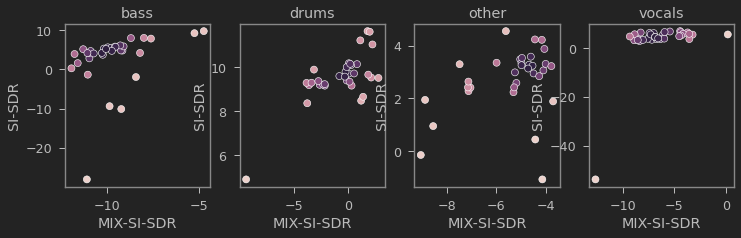

WAVE-U-NET
POP/ROCK


SNR    SI-SDR    SI-SAR
bass    2.977540  0.303948  1.237580
drums   4.433343  1.909871  2.234099
other   2.171150 -2.186309 -0.238242
vocals  4.110339  1.576554  2.744975

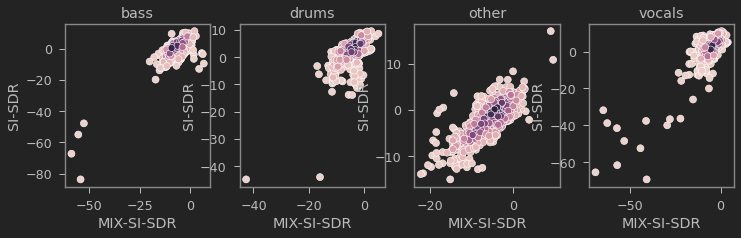

SINGER/SONGWRITER


SNR    SI-SDR    SI-SAR
bass    1.820002 -1.453520 -0.087741
drums   3.818131  0.569103  0.900434
other   2.435088 -1.602312  0.180641
vocals  4.957470  2.592947  3.887727

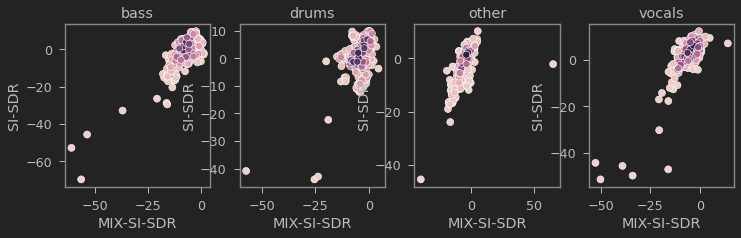

HEAVY METAL


SNR    SI-SDR    SI-SAR
bass    1.913849 -2.062453 -1.392607
drums   3.917745  1.278297  2.060969
other   2.904568 -3.091272 -1.164750
vocals  2.865897 -4.073728 -3.348481

/home/ubuntu/anaconda3/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


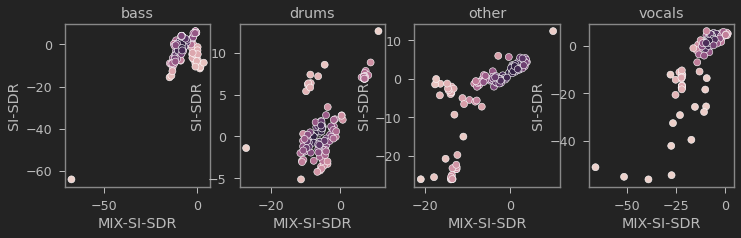

ELECTRONIC


SNR    SI-SDR    SI-SAR
bass    3.328249  1.466245  2.367266
drums   4.060119  1.540688  1.778912
other   1.935781 -2.140011 -0.443471
vocals  5.197642  3.118466  4.451133

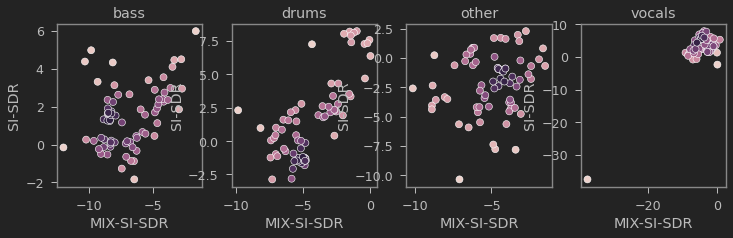

RAP


SNR    SI-SDR    SI-SAR
bass    4.121847  1.847277  2.359728
drums   2.450131 -0.221745  0.638344
other   1.764791 -3.487304 -1.469943
vocals  4.917564  2.330617  3.158539

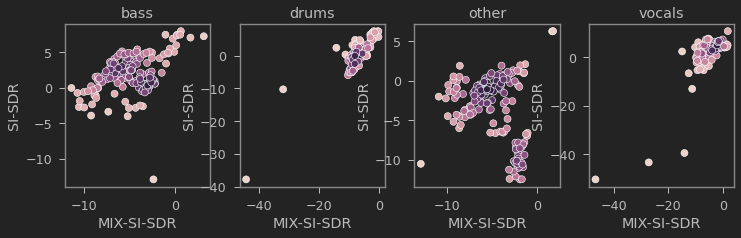

JAZZ


'No songs for genre Jazz and split train'

MUSICAL THEATRE


'No songs for genre Musical Theatre and split train'

REGGAE


'No songs for genre Reggae and split train'

COUNTRY


SNR    SI-SDR    SI-SAR
bass    3.083210  0.881046  1.322367
drums   6.612429  5.546136  5.778134
other   3.122793  0.351628  2.007486
vocals  4.565359  2.673033  3.762759

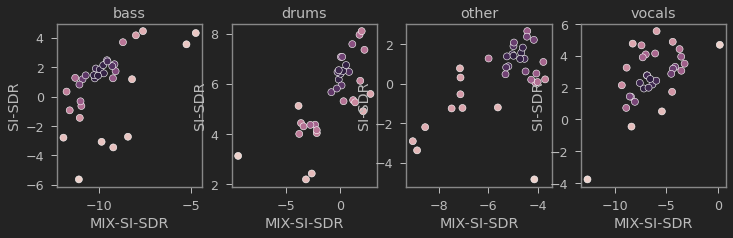

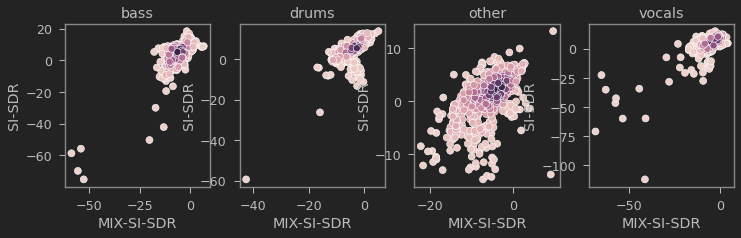

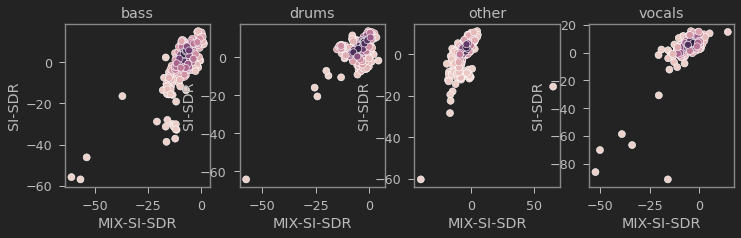

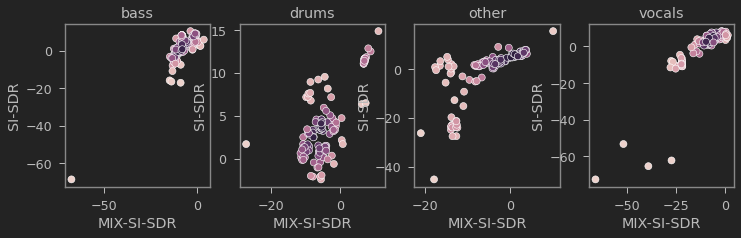

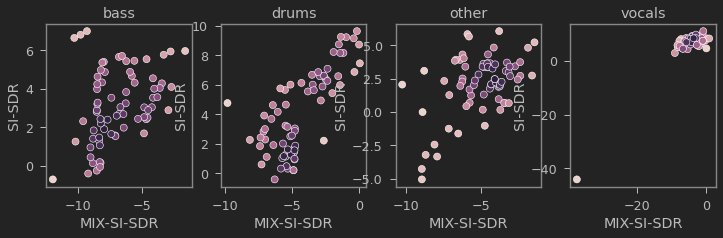

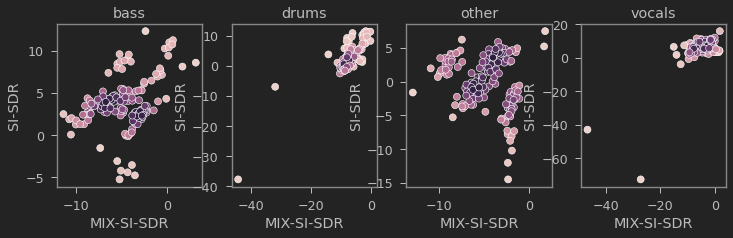

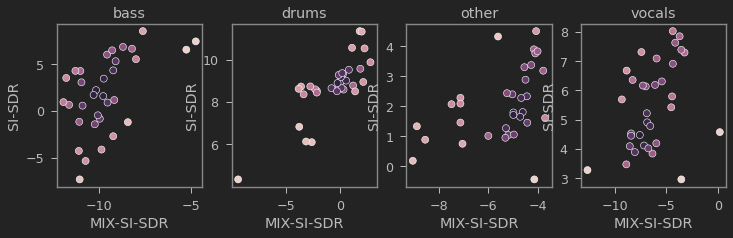

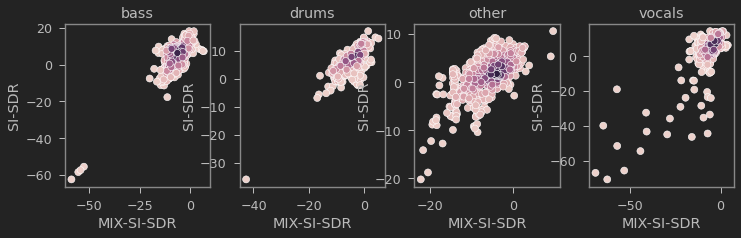

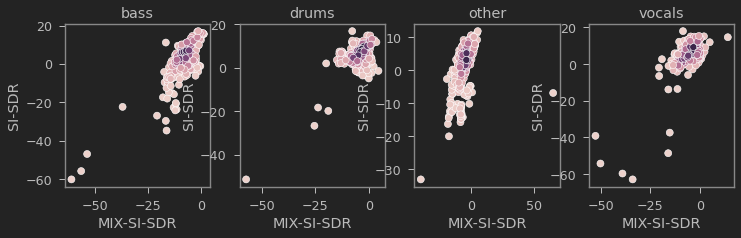

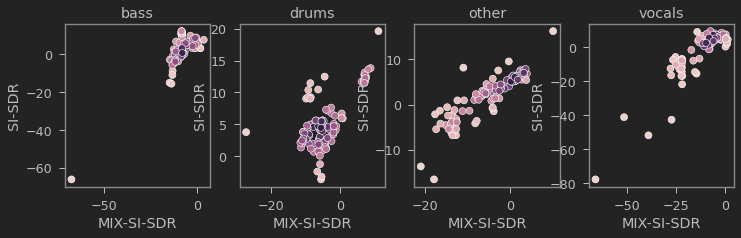

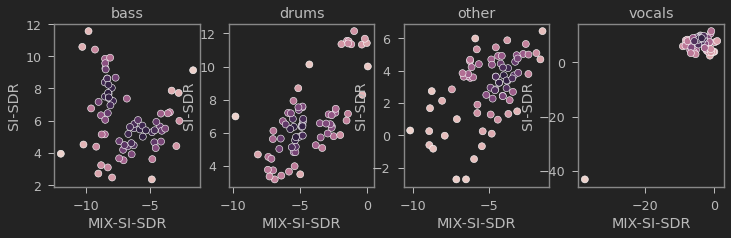

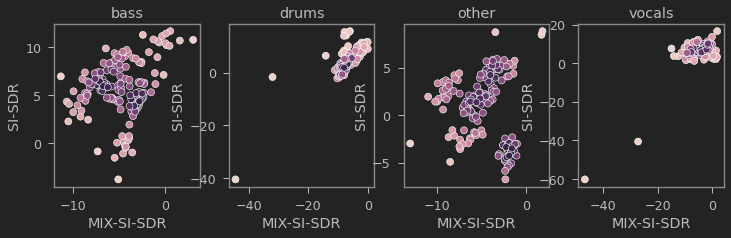

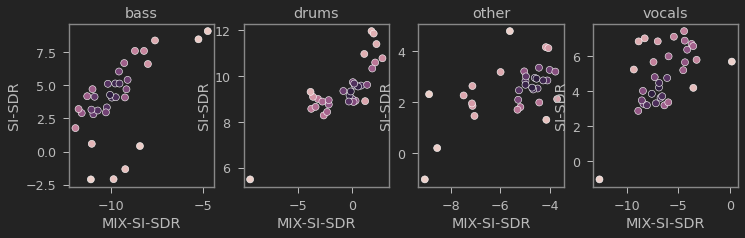

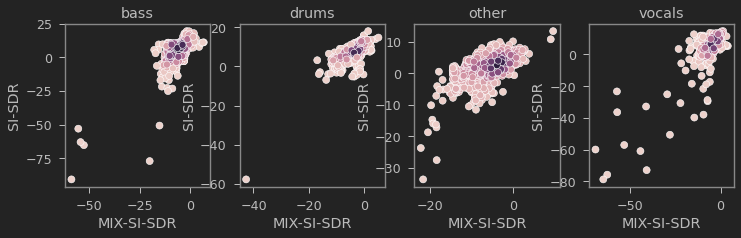

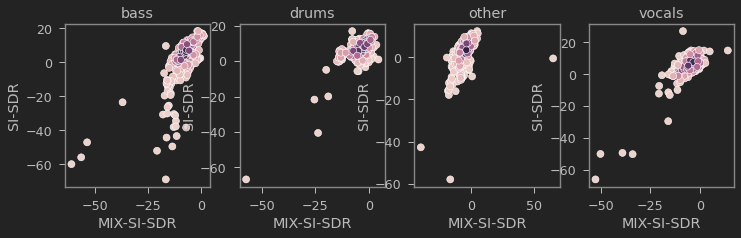

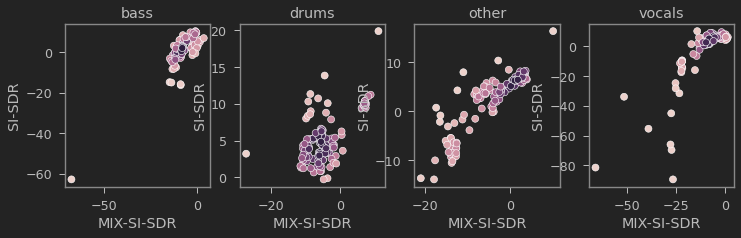

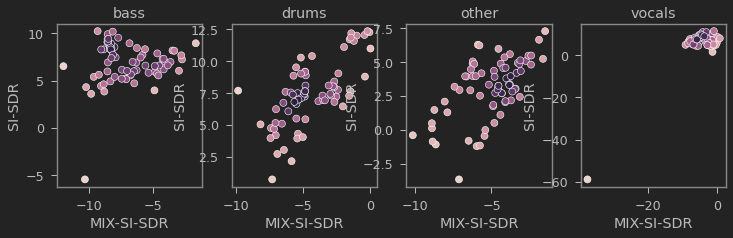

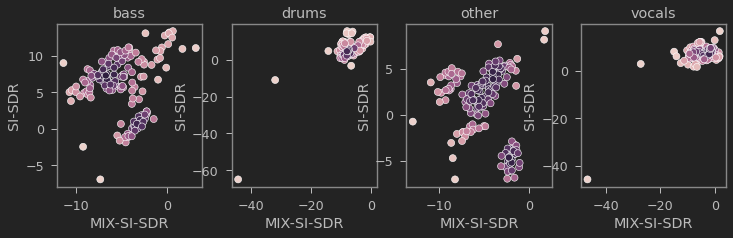

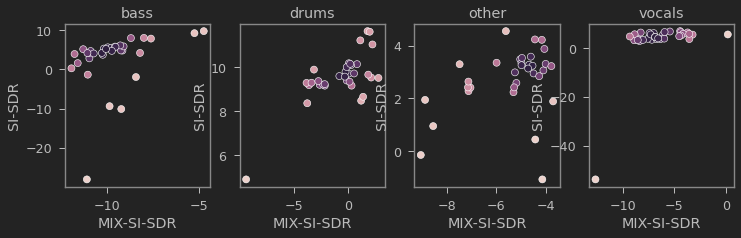

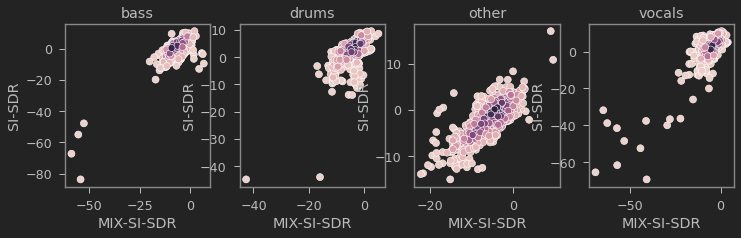

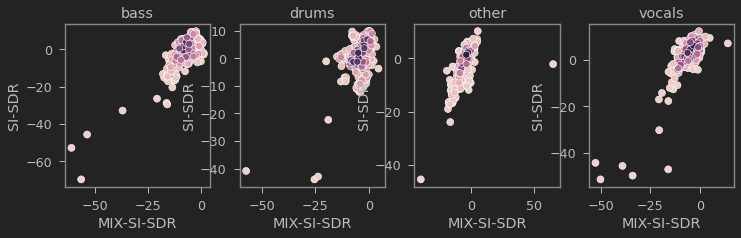

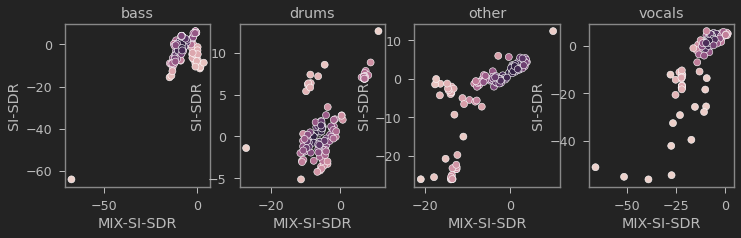

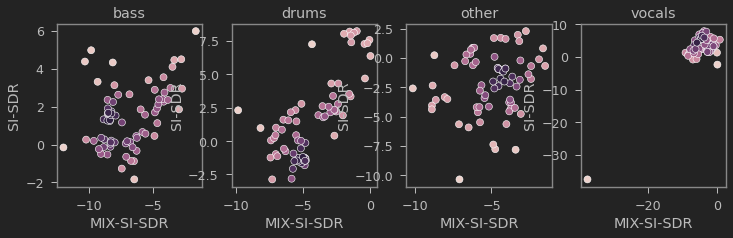

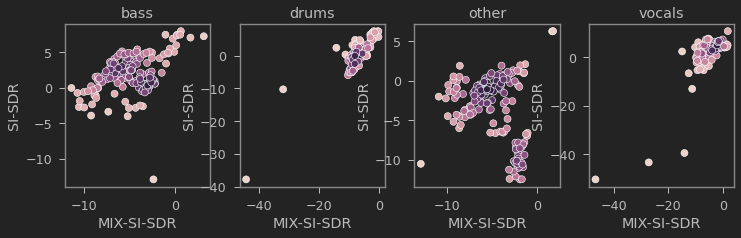

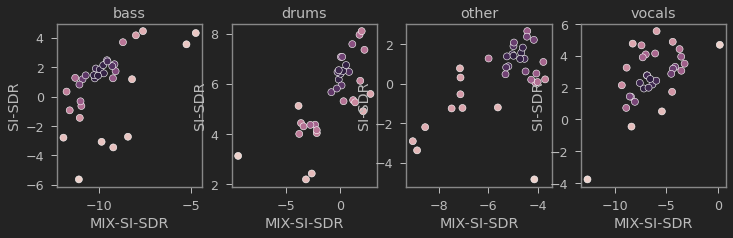

In [44]:
for key, sources_data in test_data_sources.items():
    print(key.upper())
    for genre in genres.index:
        print(genre.upper())
        display_genre_info(sources_data, genre, "train")